## iBot with ViT-S architecture with patch size=16

In [1]:
import sys
sys.path.append("../../../ssl")

In [9]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
import copy
import pickle
from augmentations.loader import get_dataloaders
from utils.eval import plot_cm_roc
from utils.eval import train
from utils.eval import test_
from models.classifier import Classifier
from utils import plot_history
from utils import set_seed
set_seed(12)

In [3]:
ckpt_path = "./ibot_vit_small_models/checkpoint.pth"
state = torch.load(ckpt_path, mmap="cpu")

### Plot for train loss vs epochs

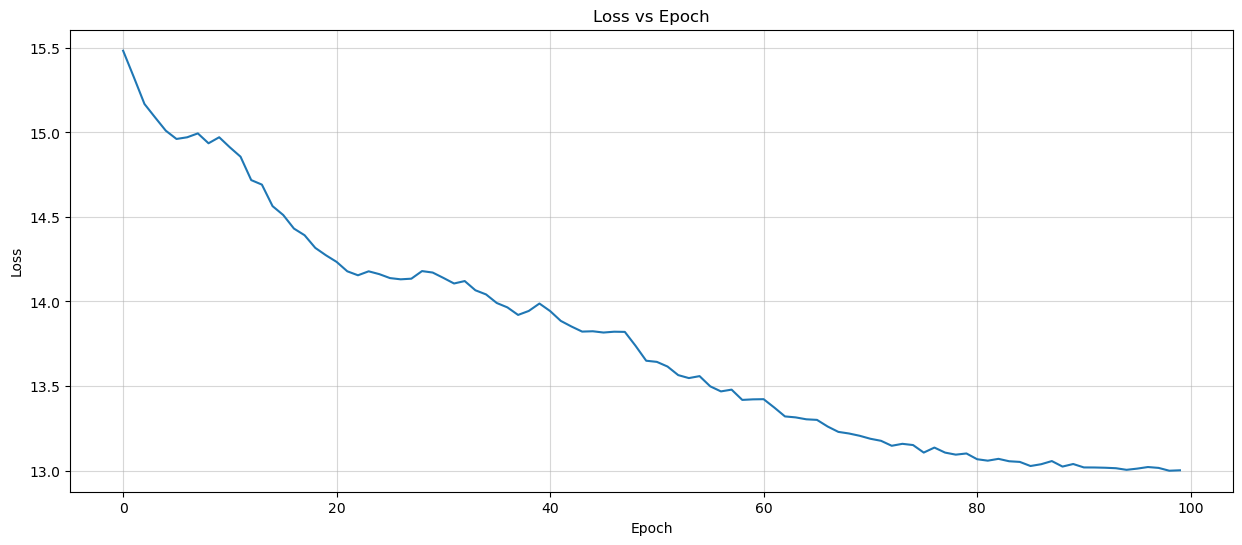

<Figure size 640x480 with 0 Axes>

In [4]:
plot_history(ckpt_path, "./train_history.png")

### Train model over the train dataset

In [5]:
eval_transforms = Transforms.Compose([
                        # Transforms.ToTensor(), # npy loader returns torch.Tensor
                        Transforms.CenterCrop(64),
                        Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                                std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
                    ])
dataloader, train_loader, val_loader, test_loader \
        = get_dataloaders(data_path="../../../input/real_lenses_dataset/", \
                          train_test_indices="../../../input/indices.pkl", \
                          state=state, eval_transforms=eval_transforms)

### Finetune the pretrained model

In [13]:
set_seed(12)

state = torch.load("./ibot_vit_small_models/checkpoint.pth")
student_network = state["student"].backbone
lp_network = Classifier(mode = "finetune", backbone = copy.deepcopy(student_network), backbone_return_all_tokens=True)
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-10)
# scheduler = None

In [14]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 0.4353, Val Loss: 0.3463, Val Accuracy: 84.52%

[2/100] Train Loss: 0.3019, Val Loss: 0.3032, Val Accuracy: 86.51%

[3/100] Train Loss: 0.2657, Val Loss: 0.2739, Val Accuracy: 87.10%

[4/100] Train Loss: 0.2501, Val Loss: 0.3540, Val Accuracy: 86.51%

[5/100] Train Loss: 0.2542, Val Loss: 0.2748, Val Accuracy: 87.70%

[6/100] Train Loss: 0.2262, Val Loss: 0.2658, Val Accuracy: 87.30%

[7/100] Train Loss: 0.2174, Val Loss: 0.2609, Val Accuracy: 87.30%

[8/100] Train Loss: 0.2046, Val Loss: 0.2794, Val Accuracy: 87.30%

[9/100] Train Loss: 0.1970, Val Loss: 0.2616, Val Accuracy: 88.10%

[10/100] Train Loss: 0.1914, Val Loss: 0.2610, Val Accuracy: 87.70%

[11/100] Train Loss: 0.2298, Val Loss: 0.2751, Val Accuracy: 86.90%

[12/100] Train Loss: 0.2079, Val Loss: 0.2856, Val Accuracy: 86.71%

[13/100] Train Loss: 0.2198, Val Loss: 0.2660, Val Accuracy: 87.50%

[14/100] Train Loss: 0.1970, Val Loss: 0.2497, Val Accuracy: 88.10%

[15/100] Train Loss: 0.1814, Val Loss: 0.25

### Test scores when the model is run on the test dataset 

In [15]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       261        |          32         |
| true nonlenses |        17        |         283         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.7369% |
|    loss   |  0.0002  |
| auc score |  0.9720  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9388  | 0.8908 |  0.9142 |   293   |
|   nonlenses    |   0.8984  | 0.9433 |  0.9203 |   300   |
| macro averaged |   0.9186  | 0.9171 |  0.9173 |         |
+----------------+-----------+--------+---------+---------+


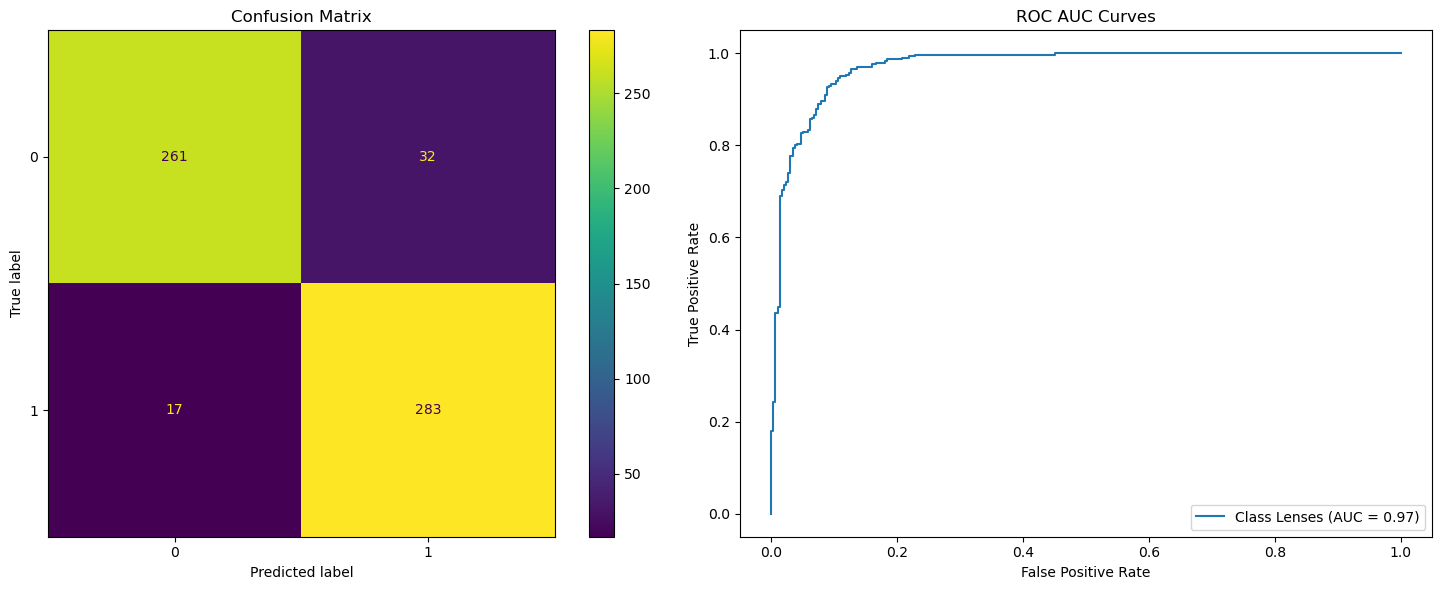

In [16]:
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [17]:
output, y_true, acc, auc = test_(lp_network, dataloader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1886       |          63         |
| true nonlenses |        33        |         1967        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.5690% |
|    loss   |  0.0025  |
| auc score |  0.9950  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9828  | 0.9677 |  0.9752 |   1949  |
|   nonlenses    |   0.9690  | 0.9835 |  0.9762 |   2000  |
| macro averaged |   0.9759  | 0.9756 |  0.9757 |         |
+----------------+-----------+--------+---------+---------+


In [18]:
with open("./classifier_network.pth", "wb") as f:
    pickle.dump(lp_network, f)